# Steps Taken

- manual data cleaning (human observation, removing data not properly seperated)
- load to notebook
- further cleaning (removing unnecessary punctuation)

## Tips

- Do not use RNNs on sets.
- RNNs are sequential - long paragraphs are not good.
- Transformers - scales really well with a large dataset
- positional encoding, attention (specifically self-attention)

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
import os
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer, AutoTokenizer
import spacy
from pickle import dump, HIGHEST_PROTOCOL


In [2]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to /Users/isabel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/isabel/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/isabel/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/isabel/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

## Get Training Data
- clean data
- lemmatize data

In [3]:
def word_cleaner(dataframe, nlp):
    # clean text to standardize (leave puncuation in as there is meaning between sentences)
    lemmatizer = WordNetLemmatizer()
    for index, row in dataframe.iterrows():
        doc = nlp(row['report'])
        list_of_words = []
        for token in doc:
            if token.pos_ == 'PROPN':
                pass
            else:
                list_of_words.append(token.text)
        r = ' '.join(list_of_words)
        r = re.sub('^a-zA-Z', ' ', r)
        r = r.replace("'s", '')
        r = r.lower()
        r = r.split()
        r = [word for word in r if word not in stopwords.words('english')]
        r = [lemmatizer.lemmatize(word) for word in r]
        r = ' '.join(r)
        r = re.sub(r'[^\w\s/]', '', r)
        r = re.sub(r'\d+', '', r)
        r = r.strip()
        dataframe.loc[index] = {'report': r, 'needs': row['needs']}
    return dataframe

In [4]:
nlp = spacy.load("en_core_web_sm")
list_of_dfs = []
for file in os.listdir('./manually_processed_data_gpt3/'):
    if '.csv' in file:
        list_of_dfs.append(word_cleaner(pd.read_csv(f'./manually_processed_data_gpt3/{file}'), nlp))

dfs = pd.concat(list_of_dfs, ignore_index=True)

In [5]:
X= np.array(list(dfs['report']))
y=np.array(list(dfs['needs']))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123)

print(f'Training Data: {X_train.shape}{y_train.shape}')
print(f'Testing Data: {X_test.shape}{y_test.shape}')

Training Data: (3865,)(3865,)
Testing Data: (1905,)(1905,)


## Methodology - 1

- bag of words representation
- logistic regression

In [8]:
# bag of words tokenization
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)

In [9]:
# logistic regression - fit the model
lr_a = LogisticRegression(solver='saga', max_iter=10000)
lr_a.fit(X_train_cv, y_train)

LogisticRegression(max_iter=10000, solver='saga')

In [10]:
X_test_cv = cv.transform(X_test)
predictions_bow = lr_a.predict(X_test_cv)

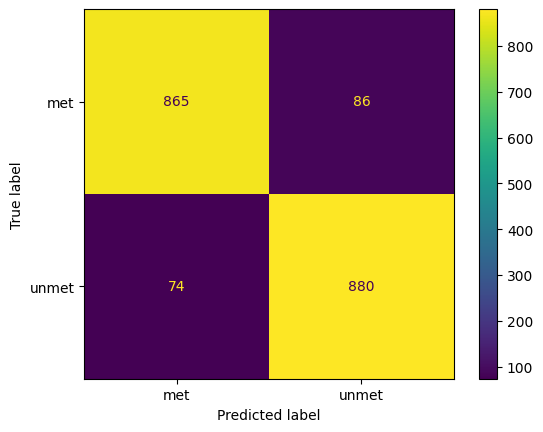

In [11]:
confusion_matrix = metrics.confusion_matrix(y_test, predictions_bow)
cm_display =metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['met', 'unmet'])
cm_display.plot()
plt.show()

In [12]:
# calculate true and false positives and negatives
true_pos = sum((yt == 'met') and (yp == 'met') for yt, yp in zip(y_test, predictions_bow))
true_neg = sum((yt == 'unmet') and (yp == 'unmet') for yt, yp in zip(y_test, predictions_bow))
false_pos = sum((yt == 'unmet') and (yp == 'met') for yt, yp in zip(y_test, predictions_bow))
false_neg = sum((yt == 'met') and (yp == 'unmet') for yt, yp in zip(y_test, predictions_bow))

# precision
prec = true_pos / (true_pos + false_pos)
print(f'Precision: {prec}')
# recall
recall = true_pos / (true_pos + false_neg)
print(f'Recall: {recall}')
# accuracy
accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)
print(f'Accuracy: {accuracy}')
# F1 score
f1 = 2 * (prec * recall) / (prec + recall)
print(f'F1 Score: {f1}')

Precision: 0.9211927582534611
Recall: 0.9095688748685594
Accuracy: 0.916010498687664
F1 Score: 0.9153439153439155


In [13]:
with open('./logisticRegressionModels/bow_logistic_regression.pkl', 'wb') as f:
    dump(lr_a, f, HIGHEST_PROTOCOL)

## Methodology - 2

- gpt-2 tokenization
- logistic regression

In [14]:
def gpt_tokenization(input_data, max_length=0):
    # gpt-2 tokens
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    list_of_gpt2_tokens = []
    for row in input_data:
        token_ids = tokenizer.encode(row, add_special_tokens=True)
        list_of_gpt2_tokens.append(token_ids)
    if max_length == 0:
        max_length = max(len(tokens) for tokens in list_of_gpt2_tokens)
    padded = [tokens + [0] * (max_length - len(tokens))for tokens in list_of_gpt2_tokens]
    return padded, max_length

In [15]:
X_train_gpt, length = gpt_tokenization(X_train)

In [16]:
# logistic regression - fit the model
lr_b = LogisticRegression(solver= 'saga', max_iter=10000)
lr_b.fit(X_train_gpt, y_train)

LogisticRegression(max_iter=10000, solver='saga')

In [17]:
X_test_gpt, max_length = gpt_tokenization(X_test, length)
predictions_gpt = lr_b.predict(X_test_gpt)
predictions_gpt

array(['unmet', 'unmet', 'met', ..., 'met', 'unmet', 'met'], dtype='<U5')

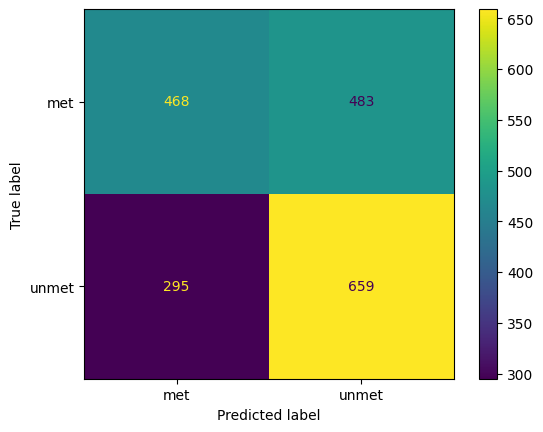

In [18]:
confusion_matrix = metrics.confusion_matrix(y_test, predictions_gpt)
cm_display =metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['met', 'unmet'])
cm_display.plot()
plt.show()

In [19]:
# calculate true and false positives and negatives
true_pos = sum((yt == 'met') and (yp == 'met') for yt, yp in zip(y_test, predictions_gpt))
true_neg = sum((yt == 'unmet') and (yp == 'unmet') for yt, yp in zip(y_test, predictions_gpt))
false_pos = sum((yt == 'unmet') and (yp == 'met') for yt, yp in zip(y_test, predictions_gpt))
false_neg = sum((yt == 'met') and (yp == 'unmet') for yt, yp in zip(y_test, predictions_gpt))

# precision
prec = true_pos / (true_pos + false_pos)
print(f'Precision: {prec}')
# recall
recall = true_pos / (true_pos + false_neg)
print(f'Recall: {recall}')
# accuracy
accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)
print(f'Accuracy: {accuracy}')
# F1 score
f1 = 2 * (prec * recall) / (prec + recall)
print(f'F1 Score: {f1}')

Precision: 0.6133682830930537
Recall: 0.4921135646687697
Accuracy: 0.5916010498687664
F1 Score: 0.5460910151691948


In [20]:
with open('./logisticRegressionModels/gpt2_logistic_regression.pkl', 'wb') as f:
    dump(lr_b, f, HIGHEST_PROTOCOL)

## Methodology - 3

- Bio_ClinicalBERT embeddings
- logistic regression

In [21]:
def bio_clinical_bert_tokenization(input_data, max_length=0):
    # bio clinical bert tokens
    tokenizer = AutoTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
    list_of_bert_tokens = []
    for row in input_data:
        token_ids = tokenizer.encode(row, add_special_tokens=True)
        list_of_bert_tokens.append(token_ids)
    if max_length == 0:
        max_length = max(len(tokens) for tokens in list_of_bert_tokens)
    padded = [tokens + [0] * (max_length - len(tokens))for tokens in list_of_bert_tokens]
    return padded, max_length

In [22]:
X_train_bert, length = bio_clinical_bert_tokenization(X_train)

In [23]:
# logistic regression - fit the model
lr_c = LogisticRegression(solver= 'saga', max_iter=10000)
lr_c.fit(X_train_bert, y_train)

LogisticRegression(max_iter=10000, solver='saga')

In [24]:
X_test_bert, max_length = bio_clinical_bert_tokenization(X_test, length)
predictions_bert = lr_c.predict(X_test_bert)
predictions_bert

array(['unmet', 'met', 'unmet', ..., 'unmet', 'met', 'met'], dtype='<U5')

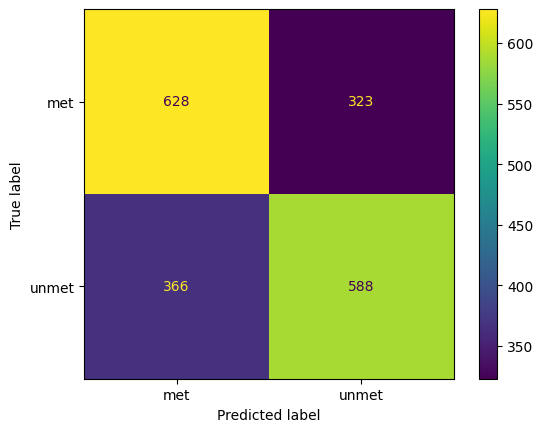

In [25]:
confusion_matrix = metrics.confusion_matrix(y_test, predictions_bert)
cm_display =metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['met', 'unmet'])
cm_display.plot()
plt.show()

In [26]:
# calculate true and false positives and negatives
true_pos = sum((yt == 'met') and (yp == 'met') for yt, yp in zip(y_test, predictions_bert))
true_neg = sum((yt == 'unmet') and (yp == 'unmet') for yt, yp in zip(y_test, predictions_bert))
false_pos = sum((yt == 'unmet') and (yp == 'met') for yt, yp in zip(y_test, predictions_bert))
false_neg = sum((yt == 'met') and (yp == 'unmet') for yt, yp in zip(y_test, predictions_bert))

# precision
prec = true_pos / (true_pos + false_pos)
print(f'Precision: {prec}')
# recall
recall = true_pos / (true_pos + false_neg)
print(f'Recall: {recall}')
# accuracy
accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)
print(f'Accuracy: {accuracy}')
# F1 score
f1 = 2 * (prec * recall) / (prec + recall)
print(f'F1 Score: {f1}')

Precision: 0.6317907444668008
Recall: 0.6603575184016824
Accuracy: 0.6383202099737533
F1 Score: 0.645758354755784


In [27]:
with open('./logisticRegressionModels/bio_clinical_bert_logistic_regression.pkl', 'wb') as f:
    dump(lr_c, f, HIGHEST_PROTOCOL)

## Methodology - 4 
- TF-IDF vectorization
- logistic regression

In [28]:
# tf-idf tokenization
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)

In [29]:
# logistic regression - fit the model
lr_d = LogisticRegression(solver='saga', max_iter=10000)
lr_d.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=10000, solver='saga')

In [30]:
X_test_tfidf = tfidf.transform(X_test)
predictions_tfidf = lr_d.predict(X_test_tfidf)

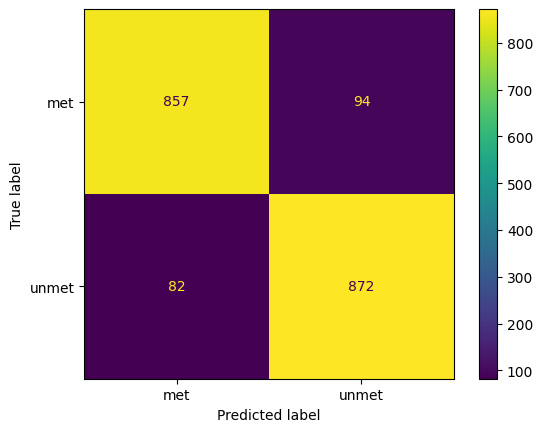

In [31]:
confusion_matrix = metrics.confusion_matrix(y_test, predictions_tfidf)
cm_display =metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['met', 'unmet'])
cm_display.plot()
plt.show()

In [32]:
# calculate true and false positives and negatives
true_pos = sum((yt == 'met') and (yp == 'met') for yt, yp in zip(y_test, predictions_tfidf))
true_neg = sum((yt == 'unmet') and (yp == 'unmet') for yt, yp in zip(y_test, predictions_tfidf))
false_pos = sum((yt == 'unmet') and (yp == 'met') for yt, yp in zip(y_test, predictions_tfidf))
false_neg = sum((yt == 'met') and (yp == 'unmet') for yt, yp in zip(y_test, predictions_tfidf))

# precision
prec = true_pos / (true_pos + false_pos)
print(f'Precision: {prec}')
# recall
recall = true_pos / (true_pos + false_neg)
print(f'Recall: {recall}')
# accuracy
accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)
print(f'Accuracy: {accuracy}')
# F1 score
f1 = 2 * (prec * recall) / (prec + recall)
print(f'F1 Score: {f1}')

Precision: 0.9126730564430245
Recall: 0.9011566771819137
Accuracy: 0.9076115485564304
F1 Score: 0.906878306878307


In [33]:
with open('./logisticRegressionModels/tfidf_logistic_regression.pkl', 'wb') as f:
    dump(lr_a, f, HIGHEST_PROTOCOL)